# Normalise mRNA data across samples

Script related to figure 5

### Aim:
- Compare and normalise gene expression values across samples

### Note:
- Gene expression data has already normalised throuh SST-RMA analysis using the Affymetrix software

In [1]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_3.5.0  IRdisplay_0.6.1 pbdZMQ_0.3-3    tools_3.5.0    
 [5] htmltools_0.3.6 base64enc_0.1-3 crayon_1.3.4    Rcpp_1.0.1     
 [9] uuid_0.1-2      IRkernel_0.8.14 jsonlite_1.6    digest_0.6.18  
[13] repr_0.17       evaluate_0.13  

## Install packages

In [ ]:
#source("http://bioconductor.org/biocLite.R")

In [ ]:
#biocLite()

In [ ]:
#biocLite("affy")

In [ ]:
#biocLite("gcrma")

In [ ]:
#biocLite("limma")

In [ ]:
#biocLite("vsn")

In [ ]:
#biocLite("reshape")

## Load packages

In [1]:
library(affy)
library(limma)
library(gplots)
library(reshape)
library(ggplot2)

Warning message:
“package ‘affy’ was built under R version 3.5.1”Loading required package: BiocGenerics
Warning message:
“package ‘BiocGenerics’ was built under R version 3.5.1”Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapply, setdiff, sor

In [2]:
setwd("~/git_repos/HGSOC_TME_Heterogeneity/")

## Load expression data

In [3]:
data <- read.table('../../Data/5/NACT_log2exp_data.txt',
                   header=T,
                   sep='\t')

In [4]:
head(data)

Hugo_Symbol,A01,A02,A03,A04,A05,A06,A07,A08,A09,⋯,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
A1BG,3.78,3.90,3.87,3.99,3.79,3.72,3.80,4.00,3.81,⋯,3.90,3.90,4.02,3.72,3.79,4.04,4.02,3.64,3.92,3.72
A2BP1,2.81,3.23,3.97,4.02,3.67,3.21,3.41,3.40,3.62,⋯,3.47,4.06,3.69,3.43,2.94,3.32,3.92,3.91,4.45,3.78
A2M,5.27,5.92,6.49,5.73,5.01,5.28,5.48,6.49,5.35,⋯,6.35,6.62,5.64,5.28,6.04,4.97,6.61,6.67,6.27,6.59
A2ML1,3.86,4.04,3.25,3.43,3.88,4.01,3.70,3.18,4.00,⋯,3.28,3.48,3.14,3.90,3.54,3.85,3.17,3.33,3.64,4.02
A4GALT,3.03,2.95,3.39,2.90,3.00,3.29,3.38,3.53,3.09,⋯,3.42,3.35,3.24,2.91,3.07,2.80,2.95,3.34,3.35,3.22
A4GNT,2.99,3.57,3.35,3.60,3.65,3.82,3.49,3.45,3.29,⋯,3.23,3.45,3.68,3.59,3.66,3.43,3.53,3.57,4.01,3.49


In [5]:
dim(data)

[1] 14668    57

In [6]:
data_mtx <- as.matrix(data[,2:57])

## Visualise gene expression distributions

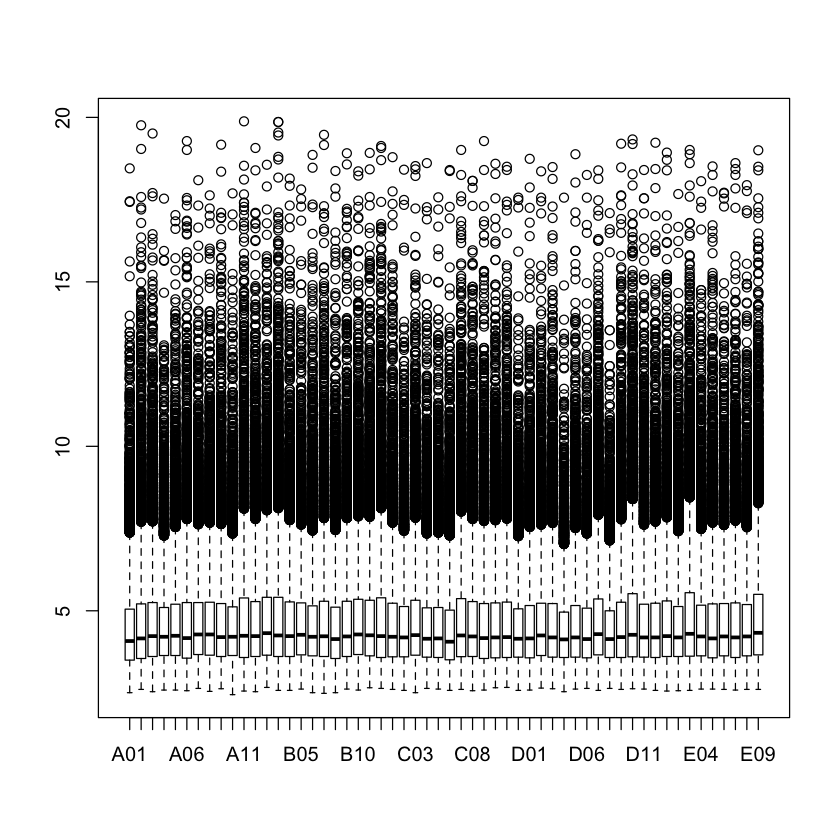

In [7]:
boxplot(data_mtx)

In [8]:
data_stacked = melt(data)

Using Hugo_Symbol as id variables


In [9]:
head(data_stacked)

Hugo_Symbol,variable,value
A1BG,A01,3.78
A2BP1,A01,2.81
A2M,A01,5.27
A2ML1,A01,3.86
A4GALT,A01,3.03
A4GNT,A01,2.99


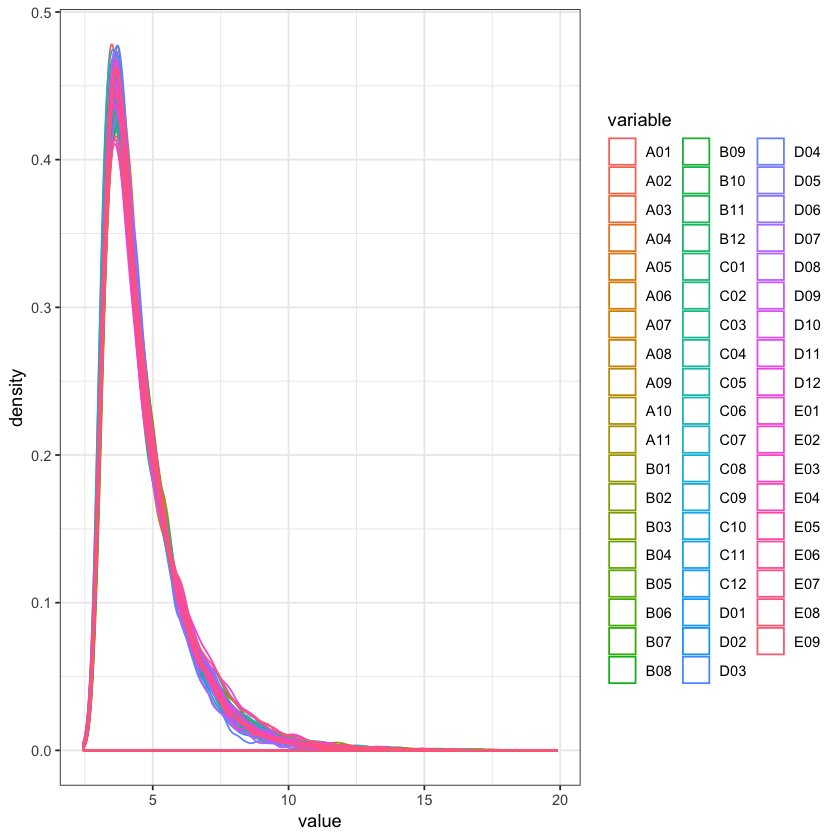

In [10]:
p <- ggplot(aes(x=value, colour=variable),
            data=data_stacked)

p + geom_density() + theme_bw()

## Test gene expression distribution difference

#### Kruskal-Wallis test by rank is a non-parametric alternative to one-way ANOVA test, which extends the two-samples Wilcoxon test in the situation where there are more than two groups. It’s recommended when the assumptions of one-way ANOVA test are not met.

In [11]:
kruskal.test(as.data.frame(data_mtx))


	Kruskal-Wallis rank sum test

data:  as.data.frame(data_mtx)
Kruskal-Wallis chi-squared = 1954.3, df = 55, p-value < 2.2e-16


##### At least one sample has different expression values than the others. Thus we proceed to normalise across samples.

## Normalise expression data

In [12]:
data_norm <- normalize.loess(data_mtx,
                             family.loess="gaussian")

Done with 1 vs 2 in iteration 1 
Done with 1 vs 3 in iteration 1 
Done with 1 vs 4 in iteration 1 
Done with 1 vs 5 in iteration 1 
Done with 1 vs 6 in iteration 1 
Done with 1 vs 7 in iteration 1 
Done with 1 vs 8 in iteration 1 
Done with 1 vs 9 in iteration 1 
Done with 1 vs 10 in iteration 1 
Done with 1 vs 11 in iteration 1 
Done with 1 vs 12 in iteration 1 
Done with 1 vs 13 in iteration 1 
Done with 1 vs 14 in iteration 1 
Done with 1 vs 15 in iteration 1 
Done with 1 vs 16 in iteration 1 
Done with 1 vs 17 in iteration 1 
Done with 1 vs 18 in iteration 1 
Done with 1 vs 19 in iteration 1 
Done with 1 vs 20 in iteration 1 
Done with 1 vs 21 in iteration 1 
Done with 1 vs 22 in iteration 1 
Done with 1 vs 23 in iteration 1 
Done with 1 vs 24 in iteration 1 
Done with 1 vs 25 in iteration 1 
Done with 1 vs 26 in iteration 1 
Done with 1 vs 27 in iteration 1 
Done with 1 vs 28 in iteration 1 
Done with 1 vs 29 in iteration 1 
Done with 1 vs 30 in iteration 1 
Done with 1 vs 31 in i

## Visualise gene normalised distributions

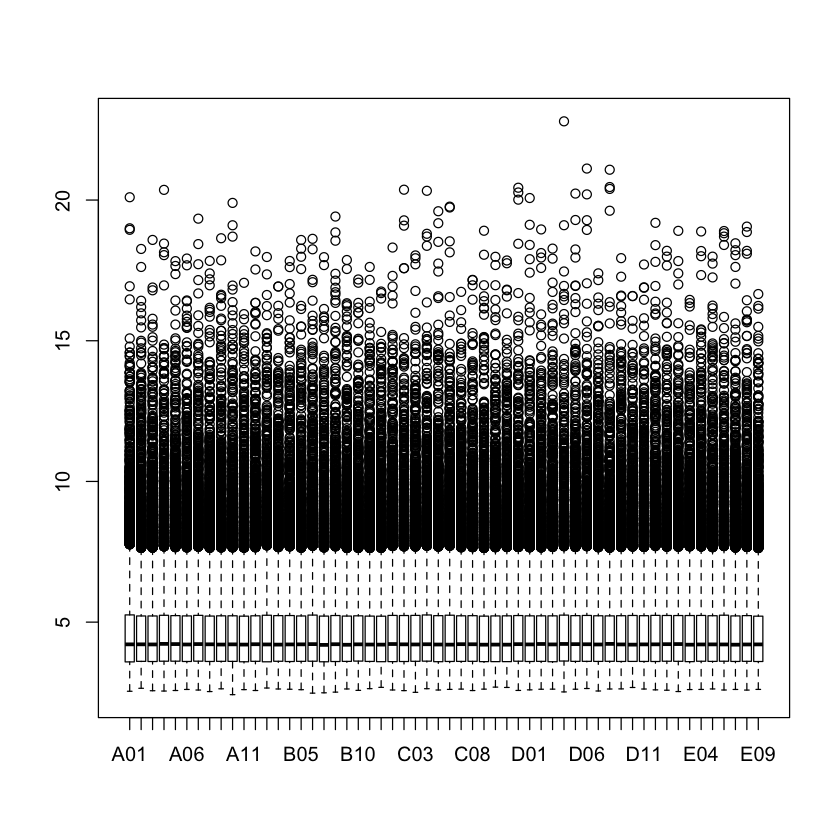

In [13]:
boxplot(data_norm)

In [14]:
data_stacked = melt(data_norm)

In [15]:
head(data_stacked)

X1,X2,value
1,A01,3.878105
2,A01,2.862997
3,A01,5.516461
4,A01,3.958668
5,A01,3.087003
6,A01,3.048008


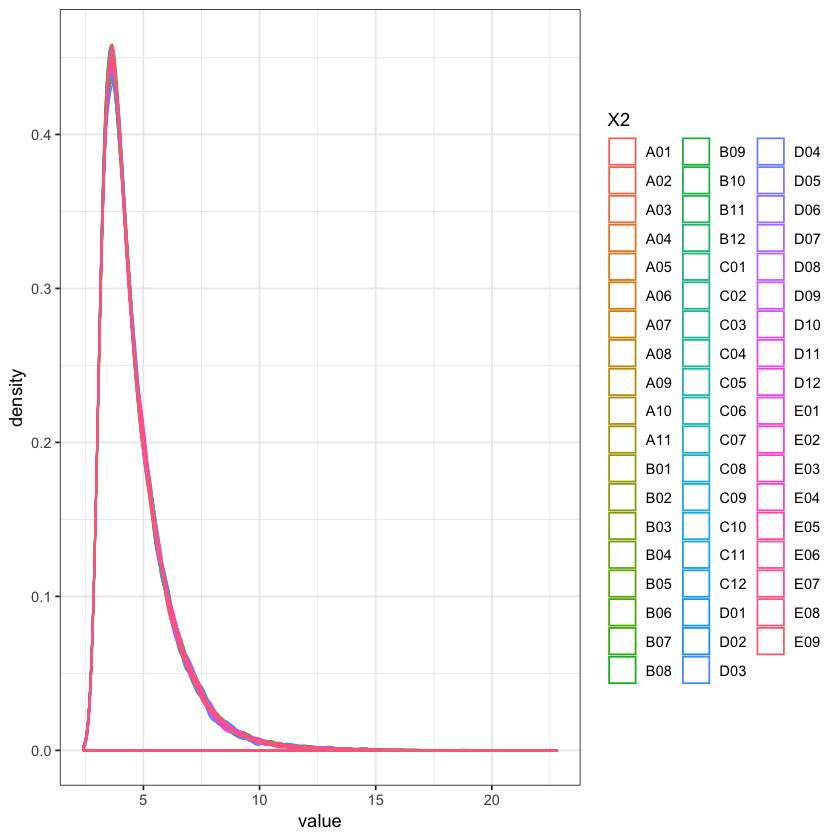

In [16]:
p <- ggplot(aes(x=value, colour=X2),
            data=data_stacked)

p + geom_density() + theme_bw()

## Test gene expression distribution difference

In [17]:
kruskal.test(as.data.frame(data_norm))


	Kruskal-Wallis rank sum test

data:  as.data.frame(data_norm)
Kruskal-Wallis chi-squared = 20.744, df = 55, p-value = 1


##### Samples are not significantly different from one another.

## Save normalised data

In [18]:
rownames(data_norm) <- data$Hugo_Symbol

In [19]:
data_norm <- data.frame("Hugo_Symbol"=rownames(data_norm),
                        data_norm)

rownames(data_norm) <- NULL

In [20]:
head(data_norm)

Hugo_Symbol,A01,A02,A03,A04,A05,A06,A07,A08,A09,⋯,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
A1BG,3.878105,3.954775,3.854334,3.974302,3.760565,3.757145,3.734362,3.935987,3.807211,⋯,3.919331,3.896646,4.027690,3.685888,3.765937,4.086110,4.000239,3.662362,3.896871,3.654871
A2BP1,2.862997,3.279474,3.957806,3.993876,3.641308,3.249292,3.347323,3.358668,3.616479,⋯,3.490291,4.059473,3.679676,3.418869,2.924245,3.346328,3.899451,3.933936,4.425151,3.723115
A2M,5.516461,5.882656,6.421447,5.980470,5.049547,5.220719,5.492205,6.471173,5.341425,⋯,6.366298,6.483692,5.784733,4.950854,6.164623,4.974455,6.709993,6.645714,6.391323,6.134008
A2ML1,3.958668,4.100177,3.250522,3.396357,3.851866,4.052745,3.635604,3.143886,3.999510,⋯,3.300078,3.488284,3.120832,3.868837,3.519030,3.891299,3.151470,3.353788,3.617326,3.950268
A4GALT,3.087003,2.995708,3.395173,2.859539,2.976988,3.332730,3.317251,3.490682,3.087911,⋯,3.440970,3.364598,3.214461,2.922184,3.054724,2.811116,2.929423,3.364648,3.325120,3.196659
A4GNT,3.048008,3.623636,3.348870,3.562907,3.620267,3.860816,3.424986,3.407024,3.285399,⋯,3.248061,3.458406,3.667137,3.574454,3.636023,3.457226,3.509265,3.593513,3.984337,3.447052


In [21]:
write.table(data_norm,
            '../../Data/5/NACT_log2exp_loess_norm.txt',
            sep='\t',
            row.names=F,
            quote=F)

# End script